# Создание модели с несколькими входами
### Объединение текстовой информации с метаинформацией и использование их в качестве входных данных для модели. Сделано при помощи API Keras (concatenate).

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to prevent tensorflow warnings!!
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from numpy import array
from keras.preprocessing.text import one_hot

from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate

import pandas as pd
import numpy as np
import re

In [2]:
yelp_reviews = pd.read_csv('./data/yelp_review_short.csv')
yelp_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [3]:
yelp_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    50000 non-null  object
 1   user_id      50000 non-null  object
 2   business_id  50000 non-null  object
 3   stars        50000 non-null  int64 
 4   date         50000 non-null  object
 5   text         50000 non-null  object
 6   useful       50000 non-null  int64 
 7   funny        50000 non-null  int64 
 8   cool         50000 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.4+ MB


In [4]:
bins = [0,1,3,5]
review_names = ['bad', 'average', 'good']
yelp_reviews['reviews_score'] = pd.cut(yelp_reviews['stars'], bins, labels=review_names)

In [5]:
yelp_reviews.sample(5)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,reviews_score
29102,j0Fd6sXUHarlMbhMNK7m1w,geEpiXM1wHwgQgWRc9tt7Q,3qrfY-XCUKVyrO5T6GskqA,5,2016-09-28,Love the food and love this place. I have orde...,0,0,0,good
43176,XSnGro0XSYxaOaKF6prjYw,UAw3pzLPfaryRFTaRek84g,RhEvP5flF6KoPriMHmVYGg,5,2016-03-21,Just am blown away by the customer service at ...,0,0,0,good
43260,VPqgOUxeIEDEPaZCGfDjIg,61AymMi8D4RTQ2aa1w41ew,KEWfF9p7SmABOl-AY0fJdg,4,2015-01-27,Just got a French manicure. The owner is very...,2,0,1,good
16618,nkGNFV1FShYSzi-nPM3npg,CFyvX-AZh6cunAMu_zoF_w,mPec-6ARme_8QAHd7tpJ8g,5,2012-01-30,This place is great. I can't do any better jo...,0,0,0,good
34291,1UmgURQD_OtaE2xzi63ieA,YwaKGmRNnSa3R3N4Hf9jLw,Sr-TfSJOxrcnByDPeAzQLQ,4,2011-02-08,I forgot that I had already reviewed this plac...,2,2,2,good


In [6]:
yelp_reviews.stars.value_counts(dropna=False)

5    20187
4    12876
3     6527
1     6263
2     4147
Name: stars, dtype: int64

In [7]:
yelp_reviews.isnull().values.any()

False

In [8]:
print(yelp_reviews.shape)

(50000, 10)


In [9]:
print(yelp_reviews["text"][3])

Love coming here. Yes the place always needs the floor swept but when you give out  peanuts in the shell how won't it always be a bit dirty. 

The food speaks for itself, so good. Burgers are made to order and the meat is put on the grill when you order your sandwich. Getting the small burger just means 1 patty, the regular is a 2 patty burger which is twice the deliciousness. 

Getting the Cajun fries adds a bit of spice to them and whatever size you order they always throw more fries (a lot more fries) into the bag.


<AxesSubplot:xlabel='reviews_score', ylabel='count'>

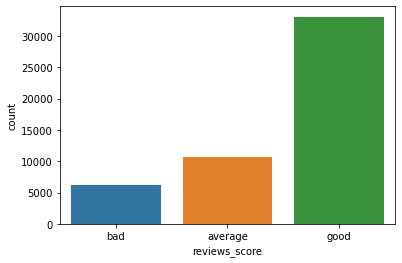

In [10]:
import seaborn as sns

sns.countplot(x='reviews_score', data=yelp_reviews)

## Создание модели только с текстовым входом

### Text preprocessing

In [11]:
def preprocess_text(sen):
    
    sentence = sen
    
    # Transform to Lowercase
#     sentence = sentence.lower()
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [12]:
X = []
sentences = list(yelp_reviews["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = yelp_reviews['reviews_score']

In [13]:
print(X[1])

Small unassuming place that changes their menu every so often Cool decor and vibe inside their seat restaurant Call for reservation We had their beef tartar and pork belly to start and salmon dish and lamb meal for mains Everything was incredible could go on at length about how all the listed ingredients really make their dishes amazing but honestly you just need to go bit outside of downtown montreal but take the metro out and it less than minute walk from the station 


Наша переменная X здесь содержит текстовые отзывы, в то время как переменная y содержит соответствующие значения reviews_score. Столбец reviews_score содержит данные в текстовом формате. Нам нужно преобразовать текст в ONE HOT ENCODED вектор. Мы можем использовать метод to_categorical из модуля keras.utils. Однако сначала мы должны преобразовать текст в целочисленные метки с помощью функции LabelEncoder из модуля sklearn.preprocessing.

In [14]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)
y

array([2, 2, 2, ..., 2, 2, 2])

In [15]:
yelp_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,reviews_score
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,good
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,good
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,good
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,good
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,good


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [18]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

### SETUP

In [19]:
# MODEL
BATCH_SIZE  = 128
EPOCHS       = 20

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 15000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200

### Токенизация

In [20]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X) # All texts, TRAIN and TEST

Предложения могут иметь разную длину, и поэтому последовательности, возвращаемые классом Tokenizer, также состоят из переменных длин. Мы указываем, что максимальная длина последовательности будет равна MAX_SEQUENCE_LENGTH = 200 (хотя можно попробовать любое число). Для предложений длиной менее 200 остальные индексы будут дополнены нулями. Для предложений, длина которых превышает MAX_SEQUENCE_LENGTH = 200, остальные индексы будут усечены.

Для того, чтобы получить число уникальных слов в тексте, можно просто посчитать длину word_index словаря tokenizer. Не забыть добавить 1 к размеру словарного запаса. Это необходимо для хранения размеров слов, для которых не существует предварительно обученных встраиваний слов.

In [21]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

61842

In [22]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'to': 3,
 'was': 4,
 'it': 5,
 'of': 6,
 'is': 7,
 'for': 8,
 'in': 9,
 'my': 10,
 'that': 11,
 'you': 12,
 'with': 13,
 'they': 14,
 'this': 15,
 'but': 16,
 'we': 17,
 'on': 18,
 'have': 19,
 'not': 20,
 'had': 21,
 'so': 22,
 'are': 23,
 'at': 24,
 'were': 25,
 'good': 26,
 'place': 27,
 'food': 28,
 'be': 29,
 'as': 30,
 'there': 31,
 'me': 32,
 'great': 33,
 'very': 34,
 'all': 35,
 'out': 36,
 'if': 37,
 'like': 38,
 'here': 39,
 'just': 40,
 'time': 41,
 'service': 42,
 'get': 43,
 'one': 44,
 'our': 45,
 'their': 46,
 'from': 47,
 'when': 48,
 'would': 49,
 'or': 50,
 'up': 51,
 'can': 52,
 'back': 53,
 'go': 54,
 'really': 55,
 'an': 56,
 'about': 57,
 'which': 58,
 'will': 59,
 'what': 60,
 'he': 61,
 'some': 62,
 'your': 63,
 'been': 64,
 'she': 65,
 'no': 66,
 'also': 67,
 'more': 68,
 've': 69,
 'only': 70,
 'i': 71,
 'them': 72,
 'because': 73,
 'by': 74,
 'nice': 75,
 'us': 76,
 'other': 77,
 'don': 78,
 'got': 79,
 'even': 80,
 'well': 81,
 'do': 

In [23]:
tokenizer.word_index.items()

dict_items([('the', 1), ('and', 2), ('to', 3), ('was', 4), ('it', 5), ('of', 6), ('is', 7), ('for', 8), ('in', 9), ('my', 10), ('that', 11), ('you', 12), ('with', 13), ('they', 14), ('this', 15), ('but', 16), ('we', 17), ('on', 18), ('have', 19), ('not', 20), ('had', 21), ('so', 22), ('are', 23), ('at', 24), ('were', 25), ('good', 26), ('place', 27), ('food', 28), ('be', 29), ('as', 30), ('there', 31), ('me', 32), ('great', 33), ('very', 34), ('all', 35), ('out', 36), ('if', 37), ('like', 38), ('here', 39), ('just', 40), ('time', 41), ('service', 42), ('get', 43), ('one', 44), ('our', 45), ('their', 46), ('from', 47), ('when', 48), ('would', 49), ('or', 50), ('up', 51), ('can', 52), ('back', 53), ('go', 54), ('really', 55), ('an', 56), ('about', 57), ('which', 58), ('will', 59), ('what', 60), ('he', 61), ('some', 62), ('your', 63), ('been', 64), ('she', 65), ('no', 66), ('also', 67), ('more', 68), ('ve', 69), ('only', 70), ('i', 71), ('them', 72), ('because', 73), ('by', 74), ('nice', 

In [24]:
print(X_train[1])

Love this place Their food is fantastic and refreshing retreat from the fast food chains that are starting to dominate the Queen and Spadina intersection The decor is colourful but minimalist and not overwhelming ve had poutine and sandwiches there and have never been disappointed They even have Fanta This is pop up spot so get there soon before it turned into another condo 


In [25]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
print(X_train[1])

[89, 15, 27, 46, 28, 7, 364, 2, 1343, 11584, 47, 1, 335, 28, 3114, 11, 23, 1826, 3, 1, 2315, 2, 8195, 8141, 1, 502, 7, 10554, 16, 9580, 2, 20, 2311, 69, 21, 1556, 2, 631, 31, 2, 19, 101, 64, 344, 14, 80, 19, 13665, 15, 7, 1319, 51, 292, 22, 43, 31, 543, 134, 5, 846, 193, 179, 5504]


In [27]:
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)

X_train.shape: (40000, 200)
X_test.shape: (10000, 200)


In [29]:
print(X_train[1])

[   89    15    27    46    28     7   364     2  1343 11584    47     1
   335    28  3114    11    23  1826     3     1  2315     2  8195  8141
     1   502     7 10554    16  9580     2    20  2311    69    21  1556
     2   631    31     2    19   101    64   344    14    80    19 13665
    15     7  1319    51   292    22    43    31   543   134     5   846
   193   179  5504     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [30]:
print(len(X_train[1]))

200


Следующий шаг - загрузить вложения слов <a href="https://nlp.stanford.edu/projects/glove/"> GloVe </a>, а затем создать нашу матрицу встраивания, которая содержит слова в нашем корпусе и соответствующие им значения из вложений GloVe.

In [31]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/data1/datasets/glove/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

Наконец, мы создадим матрицу встраивания, где количество строк будет равно количеству слов в словаре (плюс 1). Количество столбцов будет равно 100, так как каждое слово в GloVe, которые мы загрузили, представлено в виде 100-мерного вектора.

In [32]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [33]:
embedding_matrix.shape

(61842, 100)

Как только шаг встраивания слова будет завершен, мы готовы создать нашу модель. Мы будем использовать функциональный API Keras для создания нашей модели. Хотя модели с одним входом, подобные той, которую мы создаем сейчас, также могут быть разработаны с использованием последовательного API, но поскольку в следующем разделе мы собираемся разработать модель с несколькими входами, которая может быть разработана только с использованием функционального API Keras, мы будем придерживаться функционального API и в этом разделе.

Мы создадим очень простую модель с одним входным слоем (embedding layer), одним LSTM-слоем со 128 нейронами и одним плотным слоем, который также будет выступать в качестве выходного слоя. Поскольку у нас есть 3 возможных выхода, число нейронов будет равно 3, а функция активации будет softmax . Мы будем использовать categorical_cross entropy в качестве нашей функции потерь и adam в качестве функции оптимизации.

In [34]:
deep_inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [35]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          6184200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 6,301,835
Trainable params: 117,635
Non-trainable params: 6,184,200
_________________________________________________________________
None


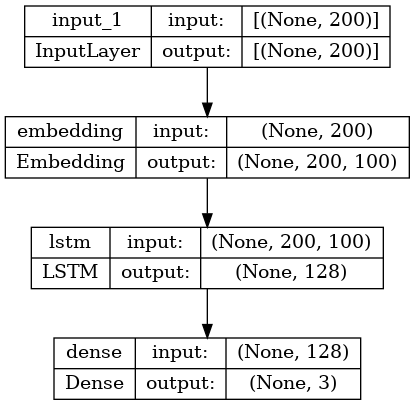

In [36]:
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

Обучаем:

In [37]:
history = model.fit(X_train, y_train, batch_size=128, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 4s 11ms/step - loss: 0.8626 - acc: 0.6597 - val_loss: 0.8555 - val_acc: 0.6639
Epoch 2/20
250/250 [==============================] - 2s 10ms/step - loss: 0.8451 - acc: 0.6639 - val_loss: 0.8406 - val_acc: 0.6664
Epoch 3/20
250/250 [==============================] - 2s 10ms/step - loss: 0.8454 - acc: 0.6641 - val_loss: 0.8404 - val_acc: 0.6636
Epoch 4/20
250/250 [==============================] - 2s 10ms/step - loss: 0.7563 - acc: 0.6779 - val_loss: 0.6254 - val_acc: 0.7308
Epoch 5/20
250/250 [==============================] - 2s 10ms/step - loss: 0.5567 - acc: 0.7599 - val_loss: 0.5476 - val_acc: 0.7707
Epoch 6/20
250/250 [==============================] - 2s 10ms/step - loss: 0.5006 - acc: 0.7885 - val_loss: 0.4885 - val_acc: 0.7918
Epoch 7/20
250/250 [==============================] - 2s 10ms/step - loss: 0.4717 - acc: 0.8018 - val_loss: 0.4735 - val_acc: 0.8010
Epoch 8/20
250/250 [==============================] - 2s 10ms/step - 

In [38]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.4752 - acc: 0.8176
Test Score: 0.47517848014831543
Test Accuracy: 0.8176000118255615


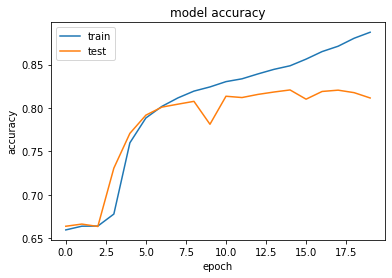

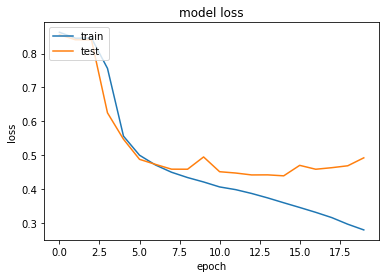

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Создание модели только с метаинформацией

<AxesSubplot:xlabel='reviews_score', ylabel='useful'>

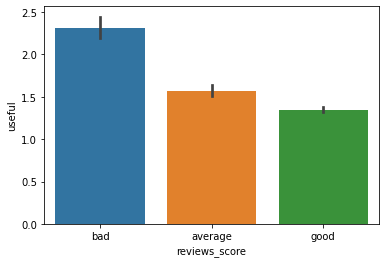

In [40]:
sns.barplot(x='reviews_score', y='useful', data=yelp_reviews)

<AxesSubplot:xlabel='reviews_score', ylabel='funny'>

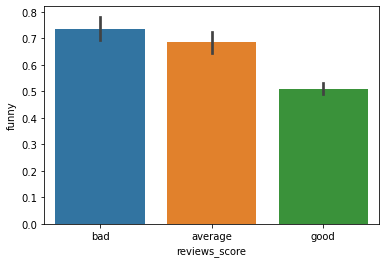

In [41]:
sns.barplot(x='reviews_score', y='funny', data=yelp_reviews)

<AxesSubplot:xlabel='reviews_score', ylabel='cool'>

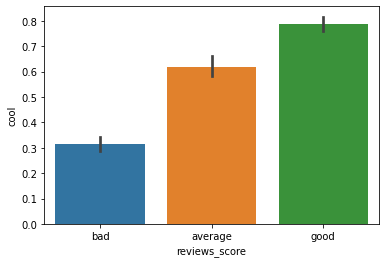

In [42]:
sns.barplot(x='reviews_score', y='cool', data=yelp_reviews)

Средний показатель для колонки cool - самый высокий для хороших отзывов, так как люди часто отмечают положительные или хорошие отзывы как классные.

Мы можем предположить, что значения count для столбцов useful, funny и cool имеют некоторую корреляцию со столбцами reviews_score. Поэтому мы попытаемся использовать данные из этих трех столбцов для обучения нашего алгоритма, который предсказывает значение для столбца reviews_score.

Отфильтруем эти три столбца из нашего набора данных:

In [43]:
yelp_reviews_meta = yelp_reviews[['useful', 'funny', 'cool']]
X = yelp_reviews_meta.values
y = yelp_reviews['reviews_score']

In [44]:
X

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 1]])

In [45]:
y

0        good
1        good
2        good
3        good
4        good
         ... 
49995    good
49996    good
49997    good
49998    good
49999    good
Name: reviews_score, Length: 50000, dtype: category
Categories (3, object): ['bad' < 'average' < 'good']

In [46]:
# from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [47]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Наша модель будет состоять из четырех слоев (можно попробовать любое количество): входной слой, два плотных скрытых слоя с 10 нейронами и функциями активации relu и, наконец, выходной плотный слой с 3 нейронами и функцией активации softmax. Функция потерь и оптимизатор будут иметь значения categorical_cross entropy и adam соответственно.

In [48]:
input2 = Input(shape=(3,))
dense_layer_1 = Dense(10, activation='relu')(input2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(3, activation='softmax')(dense_layer_2)

model = Model(inputs=input2, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [49]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 10)                40        
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________
None


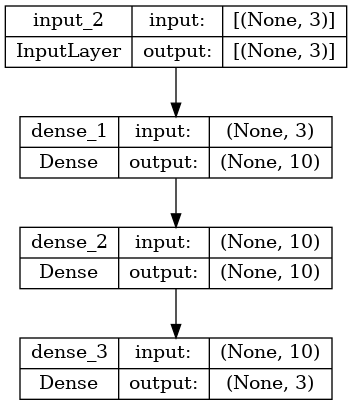

In [50]:
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

Обучаем:

In [51]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
2000/2000 [==============================] - 7s 3ms/step - loss: 0.8511 - acc: 0.6640 - val_loss: 0.8154 - val_acc: 0.6724
Epoch 2/10
2000/2000 [==============================] - 7s 3ms/step - loss: 0.8197 - acc: 0.6679 - val_loss: 0.8148 - val_acc: 0.6724
Epoch 3/10
2000/2000 [==============================] - 7s 4ms/step - loss: 0.8185 - acc: 0.6687 - val_loss: 0.8150 - val_acc: 0.6736
Epoch 4/10
2000/2000 [==============================] - 7s 4ms/step - loss: 0.8178 - acc: 0.6690 - val_loss: 0.8143 - val_acc: 0.6737
Epoch 5/10
2000/2000 [==============================] - 7s 4ms/step - loss: 0.8173 - acc: 0.6685 - val_loss: 0.8140 - val_acc: 0.6743
Epoch 6/10
2000/2000 [==============================] - 8s 4ms/step - loss: 0.8169 - acc: 0.6686 - val_loss: 0.8143 - val_acc: 0.6737
Epoch 7/10
2000/2000 [==============================] - 7s 4ms/step - loss: 0.8170 - acc: 0.6688 - val_loss: 0.8142 - val_acc: 0.6740
Epoch 8/10
2000/2000 [==============================] - 7s 4ms

Модель не обучается. Навероно потому, что входные данные явно коррелируют с выходом.

In [52]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.8205 - acc: 0.6681
Test Score: 0.8204517364501953
Test Accuracy: 0.6680999994277954


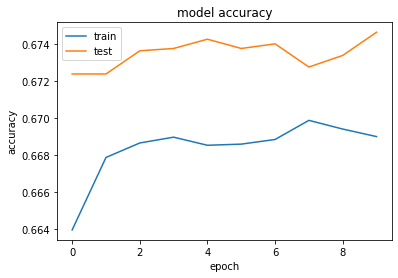

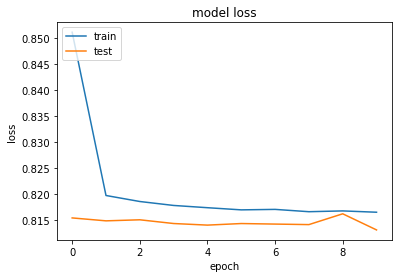

In [53]:
# import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Создание модели с несколькими входами

Мы можем объединить текстовую информацию с метаинформацией и использовать в качестве входных данных для нашей модели. Сделаем это с помощью API Keras.

 В этом разделе мы создадим две подмодели.

Первая подмодель будет принимать текстовый ввод в виде текстовых обзоров. Эта подмодель будет состоять из входного слоя формы, слоя встраивания и слоя LSTM из 128 нейронов. Вторая подмодель будет принимать входные данные в виде метаинформации из столбцов. Вторая подмодель также состоит из трех слоев. Входной слой и два плотных слоя.

Выход из слоя LSTM первой подмодели и выход из второго плотного слоя второй подмодели будут объединены вместе и будут использоваться в качестве объединенного входа в другой плотный слой с 10 нейронами. Наконец, выходной плотный слой будет иметь три нейрона, соответствующих каждому типу обзора.

In [54]:
X = yelp_reviews.drop('reviews_score', axis=1)
y = yelp_reviews['reviews_score']

In [55]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Text preprocessing

In [56]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [57]:
X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))

In [58]:
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

In [59]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X1_train + X1_test) # All texts, TRAIN and TEST

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

X1_train = pad_sequences(X1_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X1_test = pad_sequences(X1_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

print('X1_train.shape:', X1_train.shape)
print('X1_test.shape:', X1_test.shape)

vocab_size = len(tokenizer.word_index) + 1
vocab_size

X1_train.shape: (40000, 200)
X1_test.shape: (10000, 200)


61842

In [60]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/data1/datasets/glove/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [61]:
embedding_matrix.shape

(61842, 100)

In [62]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [-0.52165002, -0.10913   ,  0.38196   , ...,  0.43594   ,
        -0.33495   ,  0.18934999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34896001,  0.095218  ,  0.31503001, ...,  0.51143003,
        -0.53978002,  0.19330999]])

### Мы предварительно обработали наш текстовый ввод. Второй тип ввода-это метаинформация в столбцах.

In [63]:
X2_train = X_train[['useful', 'funny', 'cool']].values
X2_test = X_test[['useful', 'funny', 'cool']].values

Теперь создадим два входных слоя. Первый входной слой будет использоваться для текстового ввода, а второй входной слой будет использоваться для метаинформации из трех столбцов.

In [64]:
input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_2 = Input(shape=(3,))

Теперь создадим первую подмодель, которая принимает данные из первого входного слоя:

In [65]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

Аналогично, оздадим вторую подмодель, которая принимает входные данные от второго входного слоя:

In [66]:
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

Теперь у нас есть две подмодели. То, что мы хотим сделать, – это объединить выходные данные из первой подмодели с выходными данными из второй подмодели. Выход из первой подмодели - это выход из LSTM_Layer_1, а выход из второй подмодели - это выход из dense_layer_2. Мы можем использовать класс Concatenate из keras.layers.merge для объединения входных данных.

Следующий сценарий создает нашу окончательную модель:

In [67]:
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

In [68]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 100)     6184200     ['input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 10)           40          ['input_4[0][0]']                
                                                                                            

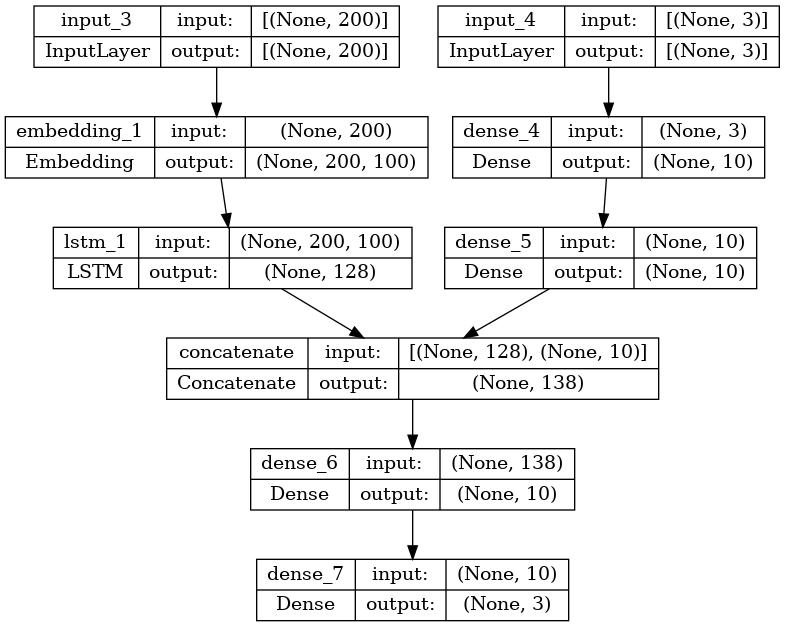

In [69]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [70]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 4s 12ms/step - loss: 0.8666 - acc: 0.6528 - val_loss: 0.8254 - val_acc: 0.6721
Epoch 2/20
250/250 [==============================] - 3s 11ms/step - loss: 0.8190 - acc: 0.6696 - val_loss: 0.8080 - val_acc: 0.6766
Epoch 3/20
250/250 [==============================] - 3s 11ms/step - loss: 0.8110 - acc: 0.6720 - val_loss: 0.8137 - val_acc: 0.6761
Epoch 4/20
250/250 [==============================] - 3s 11ms/step - loss: 0.8102 - acc: 0.6718 - val_loss: 0.8002 - val_acc: 0.6827
Epoch 5/20
250/250 [==============================] - 3s 11ms/step - loss: 0.8141 - acc: 0.6710 - val_loss: 0.8219 - val_acc: 0.6771
Epoch 6/20
250/250 [==============================] - 3s 11ms/step - loss: 0.7849 - acc: 0.6816 - val_loss: 0.7047 - val_acc: 0.7106
Epoch 7/20
250/250 [==============================] - 3s 11ms/step - loss: 0.7203 - acc: 0.6961 - val_loss: 0.6138 - val_acc: 0.7406
Epoch 8/20
250/250 [==============================] - 3s 10ms/step - 

In [71]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.4292 - acc: 0.8196
Test Score: 0.4292435646057129
Test Accuracy: 0.819599986076355


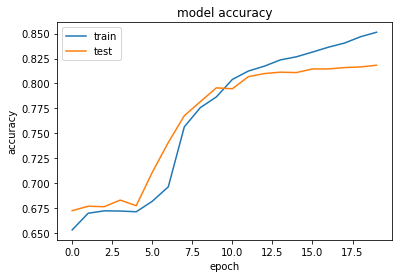

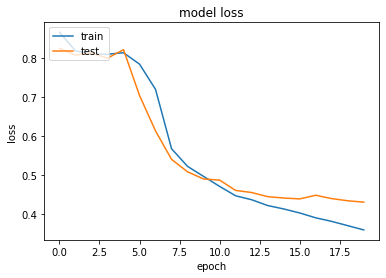

In [72]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()